In [2]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


First example is a 4d Gaussian with 2 modes, with weights defined by w1 and w2. We'll consider two sample sizes, fist 5000.

In [27]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass                                                                                                                                                                   
w2 = 1 - w1  # the other mode with 0.7 of the mass                                                                                                                                                          

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

gauss_4d_model = pm.Model()

with gauss_4d_model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_ns_nfmc(5000, rho=0.5, chains=2, frac_validate=0.2, alpha=(0,0))
    az_trace = az.from_pymc3(trace)


Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: [0.]
Stage:   2; Evidence ratio: [2.26452796e-35]
Stage:   3; Evidence ratio: [9.22784169e-19]
Stage:   4; Evidence ratio: [4.60909011e-12]
Stage:   5; Evidence ratio: [1.08643169e-08]
Stage:   6; Evidence ratio: [1.60529162e-06]
Stage:   7; Evidence ratio: [0.00012187]
Stage:   8; Evidence ratio: [0.00333423]
Stage:   9; Evidence ratio: [0.02242857]
Stage:  10; Evidence ratio: [0.0842874]
Stage:  11; Evidence ratio: [0.22098991]
Stage:  12; Evidence ratio: [0.39353856]
Stage:  13; Evidence ratio: [0.54009413]
Stage:  14; Evidence ratio: [0.67986015]
Stage:  15; Evidence ratio: [0.78463171]
Stage:  16; Evidence ratio: [0

First we'll plot up the results using 5000 samples. Note that things look ok, although the height of both peaks seems a bit high.

<Figure size 720x480 with 0 Axes>

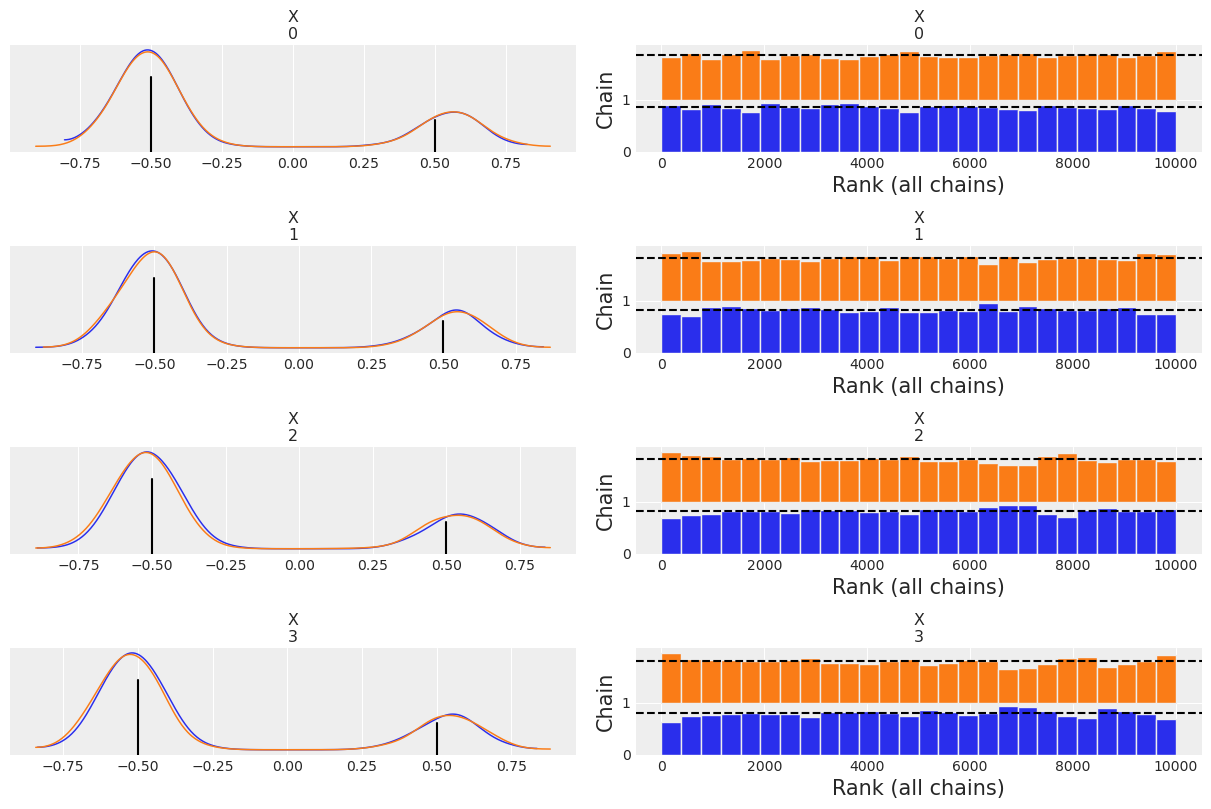

In [28]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color="k")
    ax[i, 0].axvline(0.5, 0, 0.3, color="k")
plt.show()

Now let's do the same 4d Gaussian model but with 500 samples.

In [23]:
with gauss_4d_model:
    trace = pm.sample_ns_nfmc(500, rho=0.5, chains=2, frac_validate=0.1, alpha=(0,0))
    az_trace = az.from_pymc3(trace)

Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: [0.]
Stage:   2; Evidence ratio: [3.2727537e-40]
Stage:   3; Evidence ratio: [1.69356479e-20]
Stage:   4; Evidence ratio: [4.61231095e-13]
Stage:   5; Evidence ratio: [3.14512249e-08]
Stage:   6; Evidence ratio: [3.72347489e-05]
Stage:   7; Evidence ratio: [0.00204845]
Stage:   8; Evidence ratio: [0.04219245]
Stage:   9; Evidence ratio: [0.05713767]
Stage:  10; Evidence ratio: [0.25920745]
Stage:  11; Evidence ratio: [0.42651292]
Stage:  12; Evidence ratio: [0.74244991]
Stage:  13; Evidence ratio: [0.80087754]
Stage:  14; Evidence ratio: [0.85463344]
Stage:  15; Evidence ratio: [0.90748307]
Stage:  16; Evidence ratio: [0

Now let's plot up the results with 500 samples. This isn't actually as bad as it was previously. Note that in this instance I used a smaller proportion of the samples for validation in the NF fit (0.1 vs >0.2). Would be good to work out some sensible ranges to use for this. May be able to improve this by doing some resampling from the NF fits after we've calculated all their relative weights too.

<Figure size 720x480 with 0 Axes>

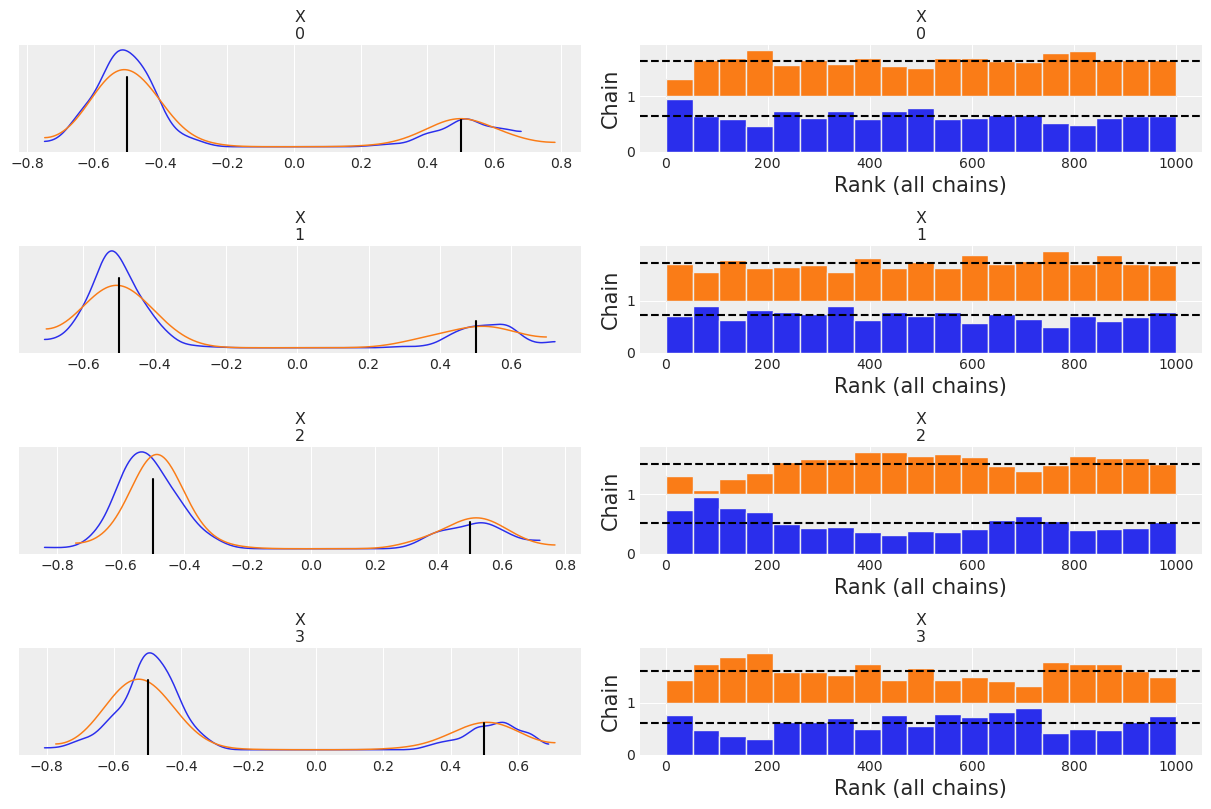

In [24]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color="k")
    ax[i, 0].axvline(0.5, 0, 0.3, color="k")
plt.show()

Second example is a basic linear regression problem, simulating a y=ax+b model. Observations are distributed as d~N(ax+b,0.1). In the first instance we draw 20000 samples, and use a high rejection fraction of rho=0.8.

In [31]:
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1, size=len(x))

reg_model = pm.Model()

with reg_model:

    a = pm.Normal('a', mu=2, sigma=1.0)
    b = pm.Normal('b', mu=1, sigma=1.0)
    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    trace = pm.sample_ns_nfmc(20000, rho=0.8, chains=2, frac_validate=0.1, alpha=(0,0))
    az_trace = az.from_pymc3(trace)
    

Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: [0.]
Stage:   3; Evidence ratio: [1.85324696e-46]
Stage:   4; Evidence ratio: [1.53065311e-10]
Stage:   5; Evidence ratio: [0.00670863]
Stage:   6; Evidence ratio: [0.36164209]
Stage:   7; Evidence ratio: [0.82618123]
Stage:   8; Evidence ratio: [0.96336905]
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: [0.]
Stage:   3; Evidence ratio: [1.87236977e-46]
Stage:   4; Evidence ratio: [4.87170894e-10]
Stage:   5; Evidence ratio: [0.01269102]
Stage:   6; Evidence ratio: [0.39197994]
Stage:   7; Evidence ratio: [0.82832344]
Stage:   8; Evidence ratio: [0.96259125]


<Figure size 720x480 with 0 Axes>

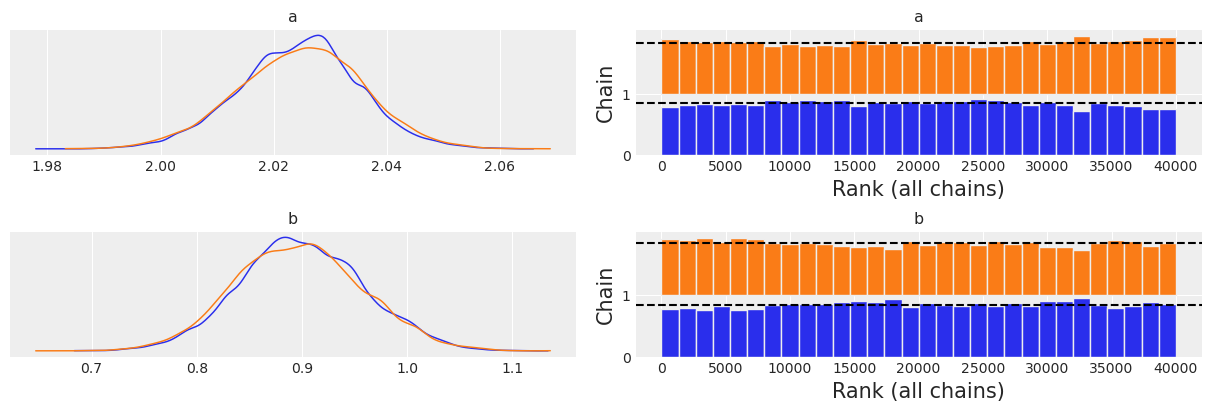

In [32]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
plt.show()

Now let's look at using 500 samples.

In [40]:
with reg_model:
    
    trace = pm.sample_ns_nfmc(500, rho=0.5, chains=2, frac_validate=0.1, alpha=(0,0))
    az_trace = az.from_pymc3(trace)


Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: 0.0
Stage:   3; Evidence ratio: [0.]
Stage:   4; Evidence ratio: [2.24298995e-81]
Stage:   5; Evidence ratio: [1.28777675e-35]
Stage:   6; Evidence ratio: [2.09539704e-14]
Stage:   7; Evidence ratio: [1.32172511e-09]
Stage:   8; Evidence ratio: [2.86019543e-05]
Stage:   9; Evidence ratio: [0.02947687]
Stage:  10; Evidence ratio: [0.24294217]
Stage:  11; Evidence ratio: [0.52688051]
Stage:  12; Evidence ratio: [0.72009283]
Stage:  13; Evidence ratio: [0.8411239]
Stage:  14; Evidence ratio: [0.90896849]
Stage:  15; Evidence ratio: [0.9543268]
Stage:  16; Evidence ratio: [0.97618364]
Stage:  17; Evidence ratio: [0.98930652]
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: 0.0
Stage:   3; Evidence ratio: [0.]
Stage:   4; Evidence ratio: [3.57703076e-148]
Stage:   5; Evidence ratio

Plotting the results for 500 samples, this isn't horribly worse. Again, probably requires some tweaking of the NF fit, and a look into resampling at the end.

<Figure size 720x480 with 0 Axes>

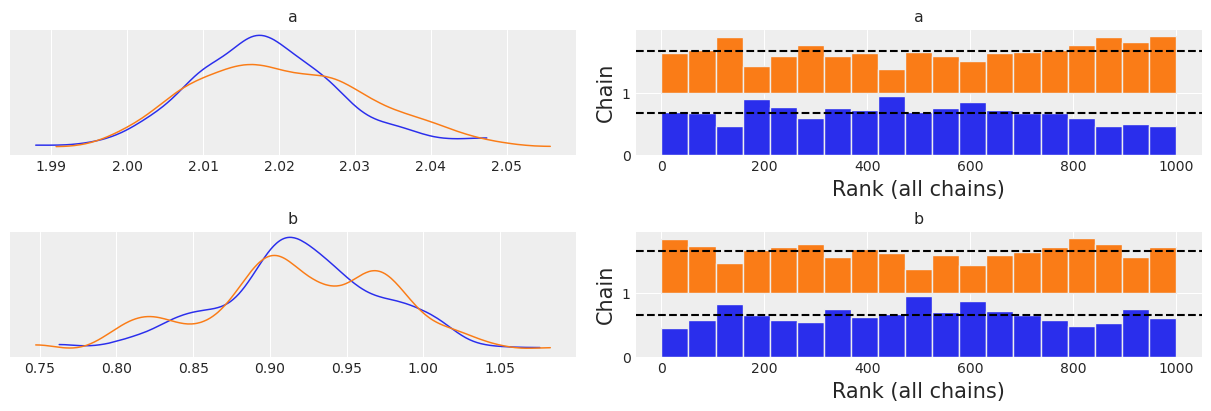

In [41]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
plt.show()

As a quick check, we can sample from the same regression model using NUTS.

In [35]:
with reg_model:
    nuts_trace = pm.sample(2000)
    nuts_az = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

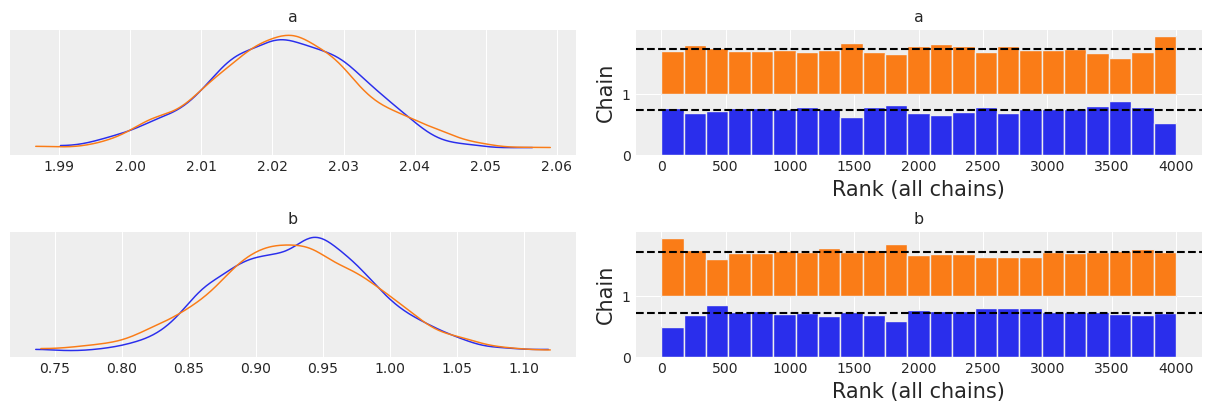

In [36]:
plt.figure()
ax = az.plot_trace(nuts_az, compact=False, kind="rank_bars")
plt.show()